In [42]:
import pandas as pd
import numpy as np
np.random.seed(12345)

In [43]:
d1 = 'ILSVRC'   # reuse-oriented
d2 = 'LibriSpeech' # sharing-based
d3 = 'IDS2018', # partially reuse-oriented
d4 = 'Inrix'    # one-time use

In [44]:
info = pd.read_csv("Datasets.csv")
info['dataset'] = info['Key'].apply(lambda x: x.split('/')[0])
costs = {row['ETag']: row['Cost'] for i, row in info.iterrows()}

In [45]:
datasets = {}
for name, group in info.groupby("dataset"):
    if name == 'IDS2018':
        group.sort_values(by='Key', inplace=True)
    datasets[name] = group

In [46]:
from EvictionPolicy import LRUCache, LFUCache, LRFUCache, RandomCache, CostAwareGreedyCache, CostAwareLRFUCache
import time

def eval(cacher, schedule):
    total_cost = 0
    for job in schedule:
        current_t = time.time()
        for chunk in job:
            if cacher.get(chunk[1], current_t) == -1:
                cacher.put(chunk[1], chunk[3], current_t)
                total_cost += chunk[0]/8  # because downloading data used 8 processes
    return total_cost


def main(storage_capacity, reuse_n, share_n, last_n):
    d3_idx = 0
    d3_data = datasets['IDS2018'].values
    sliding_d3 = []
    for i in range(last_n, len(d3_data)):
        sliding_d3.append(d3_data[i-last_n: i+1])
    
    ss = [d1] * reuse_n + [d2] * share_n + ([d3] * len(sliding_d3)) + [d4]
    np.random.shuffle(ss)
    schedule = []
    for d in ss:
        if d == d3:
            schedule.append(sliding_d3[d3_idx])
            d3_idx += 1
        elif d == d2:
            tmp = []
            for v in datasets[d].values:
                for _ in range(share_n):
                    tmp.append(v)
            schedule.append(tmp)
        else:
            tmp = list(datasets[d].values)
            schedule.append(tmp)
    
    lru = LRUCache(storage_capacity)
    lru_rlt = eval(lru, schedule)

    lfu = LFUCache(storage_capacity)
    lfu_rlt = eval(lfu, schedule)

    rand = RandomCache(storage_capacity)
    rand_rlt = eval(rand, schedule)

    lrfu = LRFUCache(storage_capacity)
    lrfu_rlt = eval(lrfu, schedule)

    greedy = CostAwareGreedyCache(storage_capacity, costs)
    greedy_rlt = eval(greedy, schedule)

    clrfu = CostAwareLRFUCache(storage_capacity, costs)
    clrfu_rlt = eval(clrfu, schedule)
    
    return [lru_rlt, lfu_rlt, rand_rlt, lrfu_rlt, greedy_rlt, clrfu_rlt]

In [47]:
data = []
storage_capacity_range = np.arange(160, 280, 20, dtype=int) * 1e9
reuse_n_range = np.arange(1, 6, 2, dtype=int)
share_n_range = np.arange(1, 8, 2, dtype=int)
last_n_range = np.arange(1, 8, 2, dtype=int)

for storage_capacity in storage_capacity_range:
    for reuse_n in reuse_n_range:
        for share_n in share_n_range:
            for last_n in last_n_range:
                for _ in range(50):
                    data.append(main(storage_capacity, reuse_n, share_n, last_n))
data = pd.DataFrame(data, columns=['LRU', 'LFU', 'LRFU', 'Random', 'Greedy', 'CostAwareLRFU'])
data.to_csv("results.csv", index=False)

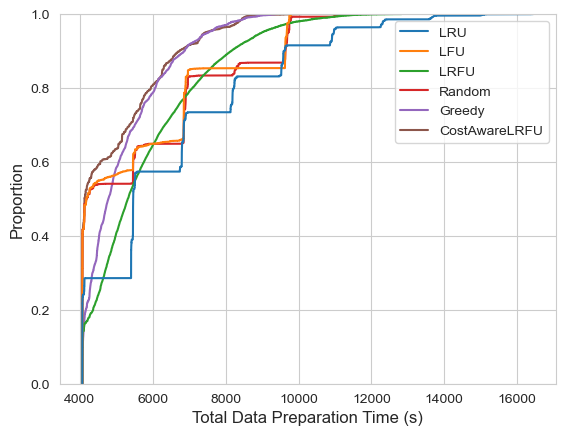

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

sns.ecdfplot(data=data)
plt.xlabel("Total Data Preparation Time (s)", fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.savefig("images/proportion.png", dpi=300)
plt.show()
